In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

from IPython import display # to display and play audio files

In [3]:
import seaborn as sns

In [4]:
# Set the seed value for experiment reproducibility.
seed = 99
tf.random.set_seed(seed)
np.random.seed(seed)

In [5]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')
  

182082353/182082353 [==============================] - 8s 0us/step


In [6]:
# Running shell commands to delete unwanted labels
%rm -rf data/mini_speech_commands/down
%rm -rf data/mini_speech_commands/up
%rm -rf data/mini_speech_commands/left
%rm -rf data/mini_speech_commands/right
%rm -rf data/mini_speech_commands/yes
%rm -rf data/mini_speech_commands/no

In [7]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['stop' 'go']


In [8]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Using 400 files for validation.

label names: ['go' 'stop']


In [9]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

train_ds.element_spec

(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [10]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [11]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


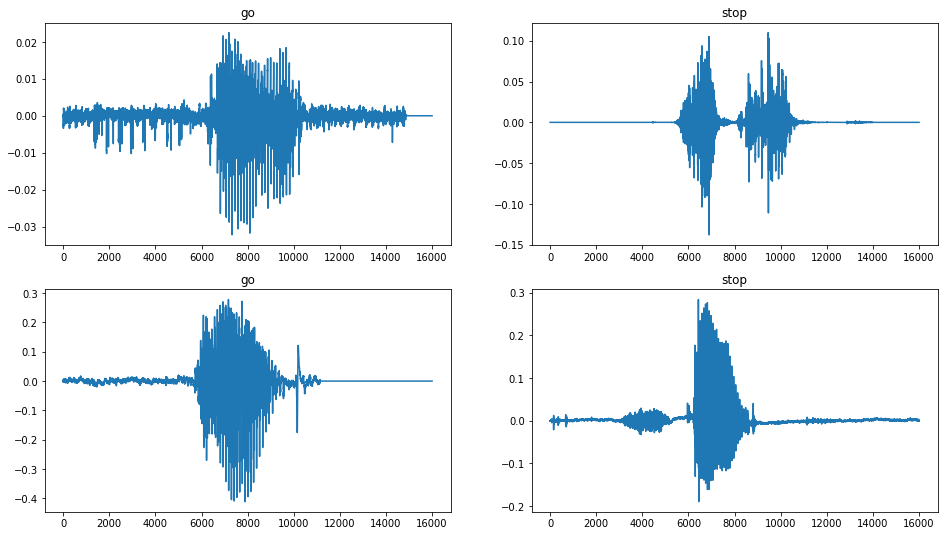

In [12]:
rows = 2
cols = 2
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy()) # .numpy() returns tensor as an n-dim array
  
  label = label_names[example_labels[i]]
  ax.set_title(label)

plt.show()

In [14]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)

  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [15]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: stop
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [16]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  print("Spectrogram shape:", log_spec.shape)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int) # Array with values in an interval
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

Spectrogram shape: (129, 124)


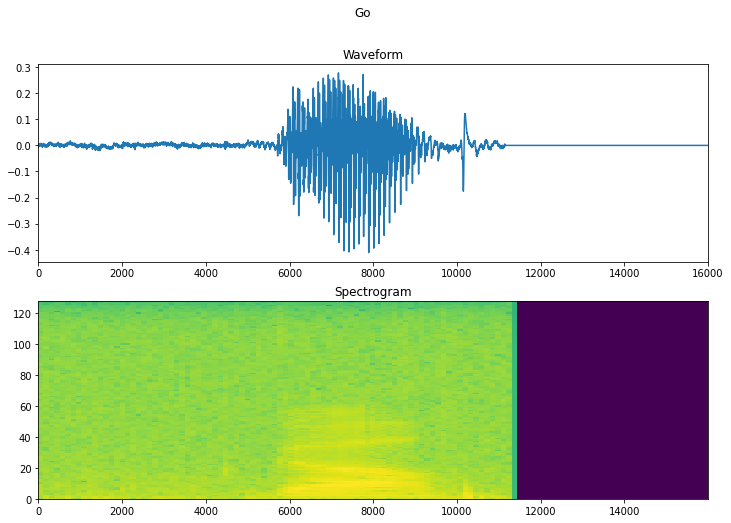

In [17]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [18]:
def make_spec_ds(ds):
  return ds.map(
      map_func= lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [19]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [21]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

Spectrogram shape: (129, 124)
Spectrogram shape: (129, 124)
Spectrogram shape: (129, 124)
Spectrogram shape: (129, 124)
Spectrogram shape: (129, 124)
Spectrogram shape: (129, 124)
Spectrogram shape: (129, 124)
Spectrogram shape: (129, 124)
Spectrogram shape: (129, 124)


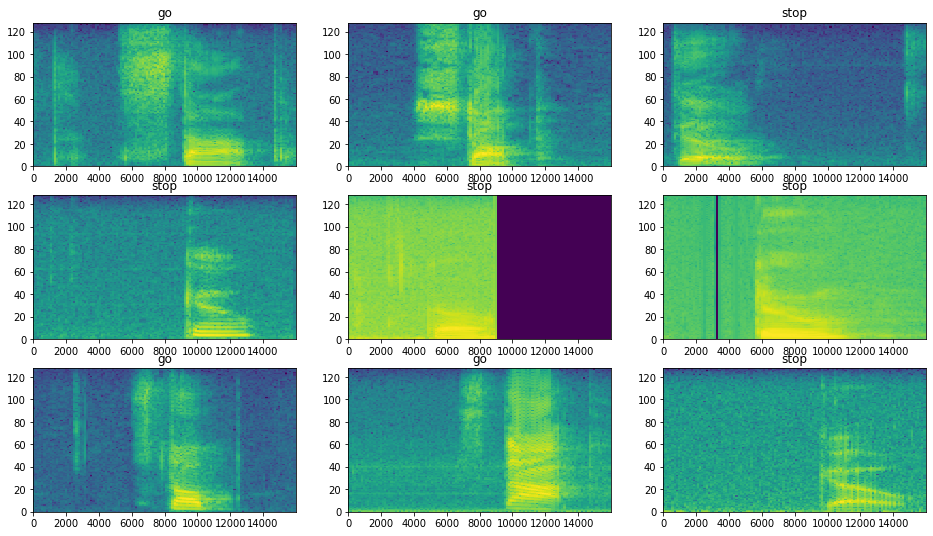

In [22]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(commands[example_spect_labels[i].numpy()])

plt.show()

In [23]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [24]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 flatten (Flatten)           

In [25]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [26]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
25/25 [==============================] - 7s 40ms/step - loss: 0.5516 - accuracy: 0.7269 - val_loss: 0.3885 - val_accuracy: 0.8594
Epoch 2/10
25/25 [==============================] - 0s 5ms/step - loss: 0.3826 - accuracy: 0.8425 - val_loss: 0.3274 - val_accuracy: 0.8958
Epoch 3/10
25/25 [==============================] - 0s 5ms/step - loss: 0.3296 - accuracy: 0.8750 - val_loss: 0.2655 - val_accuracy: 0.8958
Epoch 4/10
25/25 [==============================] - 0s 5ms/step - loss: 0.2685 - accuracy: 0.8956 - val_loss: 0.2500 - val_accuracy: 0.9271
Epoch 5/10
25/25 [==============================] - 0s 6ms/step - loss: 0.2274 - accuracy: 0.9075 - val_loss: 0.2245 - val_accuracy: 0.9323
Epoch 6/10
25/25 [==============================] - 0s 6ms/step - loss: 0.2077 - accuracy: 0.9169 - val_loss: 0.2055 - val_accuracy: 0.9271
Epoch 7/10
25/25 [==============================] - 0s 5ms/step - loss: 0.1842 - accuracy: 0.9269 - val_loss: 0.2180 - val_accuracy: 0.9375
Epoch 8/10
25/25 [=

Text(0, 0.5, 'Accuracy [%]')

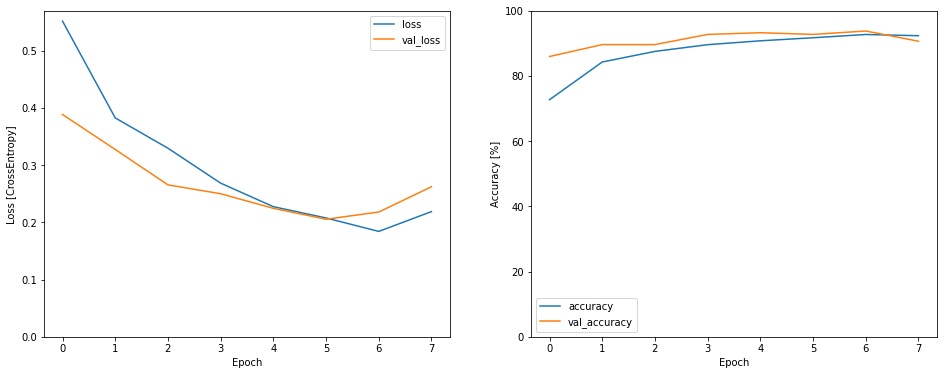

In [27]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [28]:
model.evaluate(test_spectrogram_ds, return_dict=True)

4/4 [==============================] - 0s 77ms/step - loss: 0.1808 - accuracy: 0.9087


{'loss': 0.18075290322303772, 'accuracy': 0.9086538553237915}

In [29]:
y_pred = model.predict(test_spectrogram_ds)

4/4 [==============================] - 0s 4ms/step


In [30]:
y_pred = tf.argmax(y_pred, axis=1)

In [31]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

### Confusion matrix



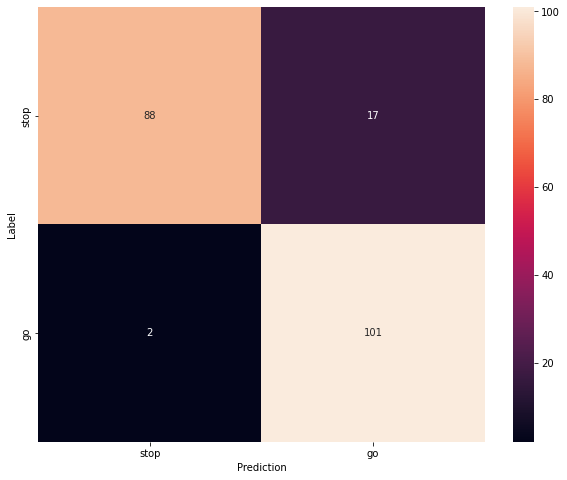

In [32]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

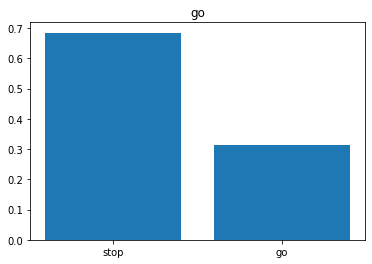

In [37]:
def preprocess(filename):
  x = data_dir/filename
  x = tf.io.read_file(str(x))
  x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
  x = tf.squeeze(x, axis=-1)
  waveform = x
  x = get_spectrogram(x)
  x = x[tf.newaxis,...]
  return x

prediction = model(preprocess("go/004ae714_nohash_0.wav"))
plt.bar(commands, tf.nn.softmax(prediction[0]))
plt.title('go')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [38]:
tf.saved_model.save(model, "saved")

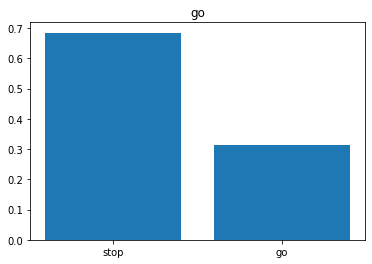

In [39]:
saved_model = tf.saved_model.load("saved")
prediction = saved_model(preprocess("go/004ae714_nohash_0.wav"))
plt.bar(commands, tf.nn.softmax(prediction[0]))
plt.title('go')
plt.show()